<a href="https://colab.research.google.com/github/ddekun/Intro_Neural_Networks/blob/lesson7/lesson7/hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение в нейронные сети

### Домашнее задание №7

1. Сделайте краткий обзор любой статьи посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

EfficientDet - масштабируемое и эффективное обнаружение объектов
источники:

https://github.com/google/automl/tree/master/efficientdet

https://arxiv.org/pdf/1911.09070.pdf

https://habr.com/ru/post/503766/


Общая архитектура EfficientDet в значительной степени соответствует парадигме одноступенчатых (one-stage) детекторов. За основу взята EfficientNet(класс моделей, который получился из изучения масштабирования scaling моделей и балансирования между собой глубины и ширины (количества каналов) сети, а также разрешения изображений в сети), предобученная на ImageNet, к ней приделан слой со взвешенной двунаправленной пирамидой признаков (BiFPN - позволяет повысить эффективность модели за счет удаления потенциально "лишних" узлов и добавления дополнительных ребер из исходного в выходной узел, чтобы объединить больше функций без дополнительных затрат), за которым идёт классовая и блочная сеть для генерации предсказаний класса объекта и ограничивающего прямоугольника соответственно.

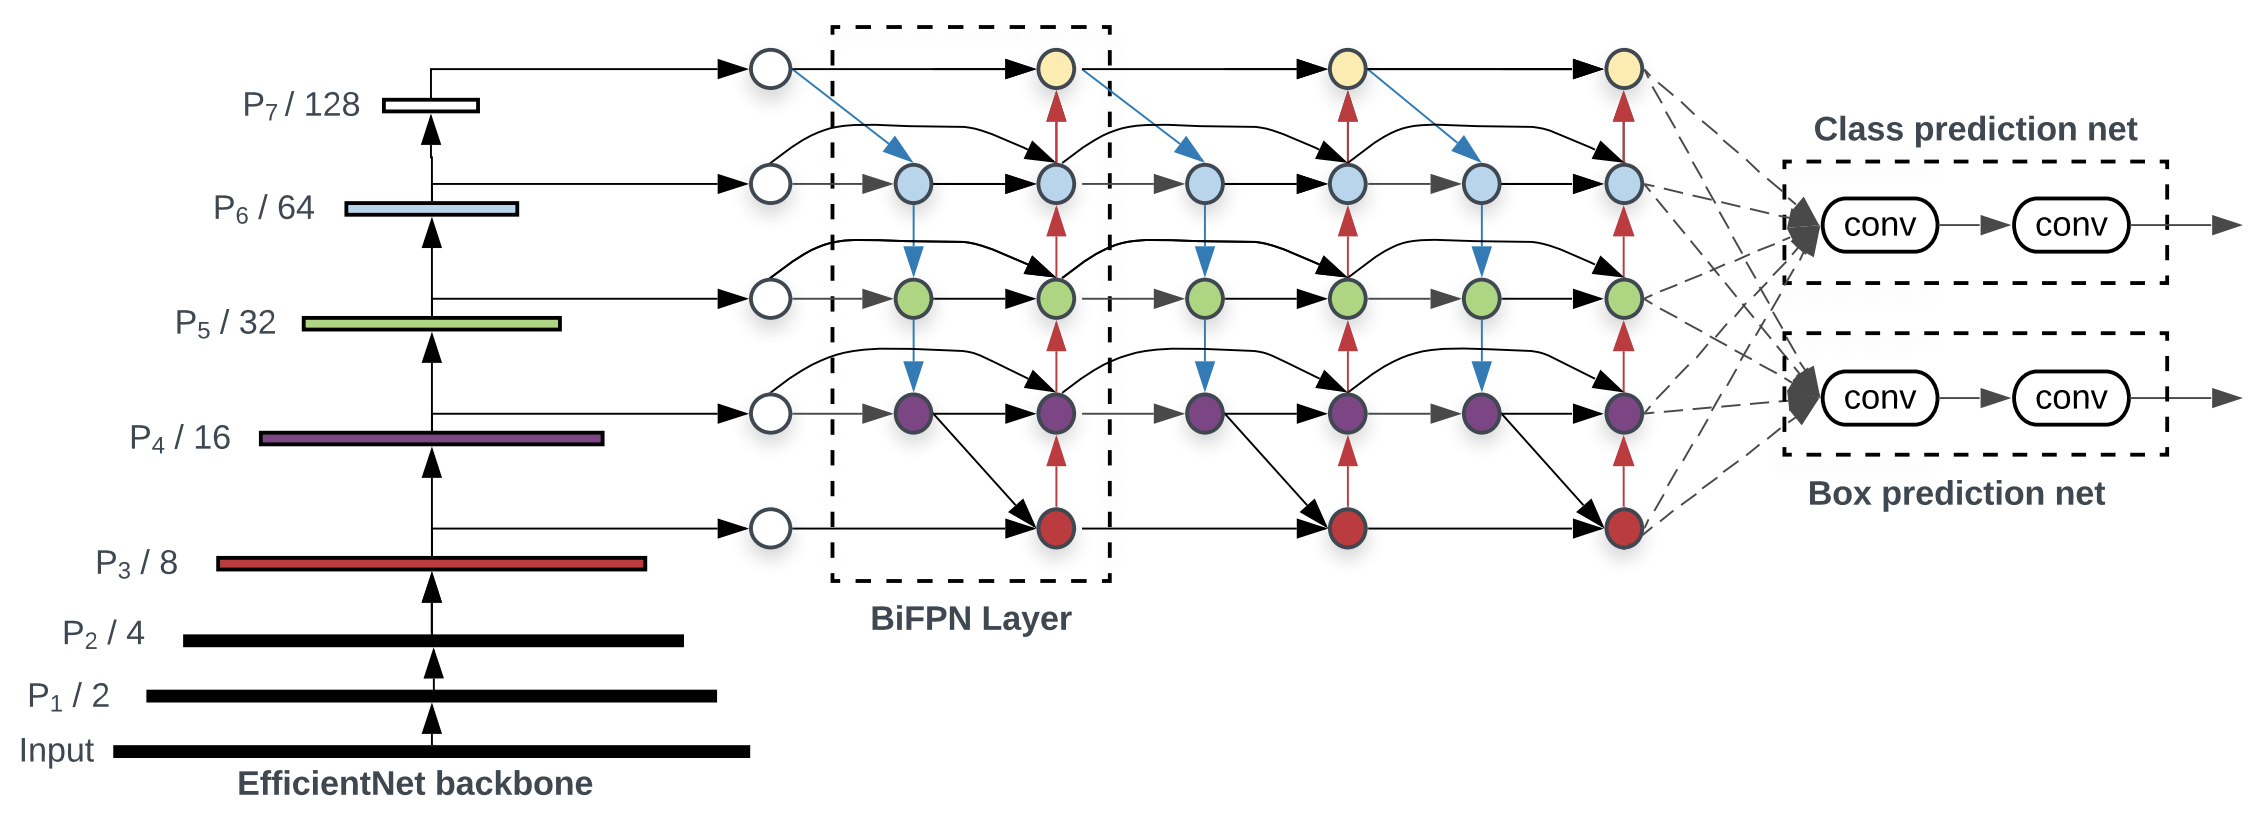

Также в EfficientDet используется нормализованное relu (Relu(w[i])/(sum(Relu(w[k])) + 0.001) где sum Суммирует по всем k) вместо SoftMax, в основе которой лежит метод быстрой нормализации слияния, который обеспечивает такую же точность, что и слияние на основе Softmax, но работает быстрее в 1,26-1,31 раза на графических процессорах.

Помимо этого, была улучшена производительность в классификации изображений с помощью совместного увеличения всех размеров сети, глубины и входного разрешения.

Благодаря всему этому, новое семейство детекторов под названием EfficientDet, последовательно достигает большей точности и эффективности, чем предшествующий уровень техники, при широком спектре ограничений по ресурсам. Так, например, по заявлению разработчиков, EfficientDet-D7 достигает современной точности с меньшим количеством параметров и FLOPS, чем лучший из существующих детекторов. EfficientDet также в 3,2 раза быстрее на GPU и в 8,1 раза быстрее на CPU.

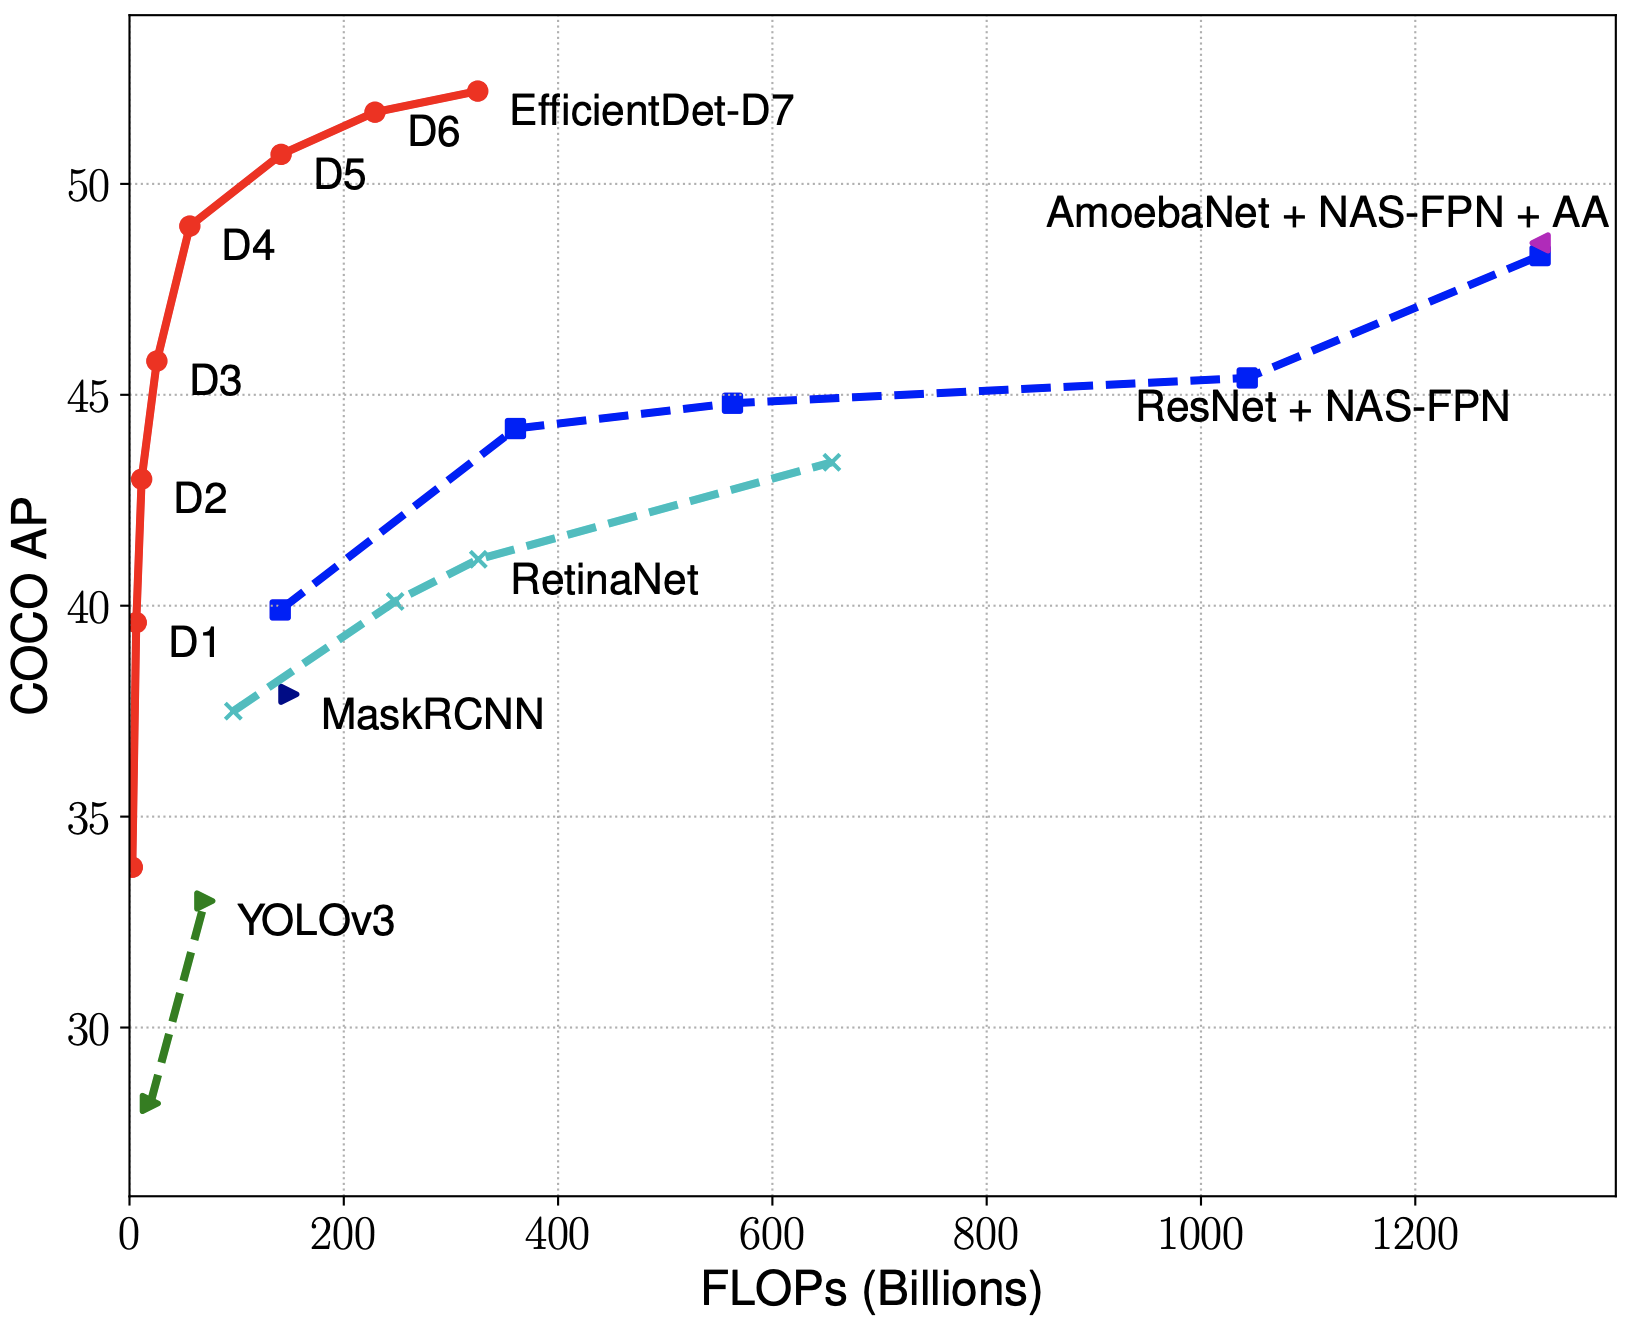

Но это все в теории. На практике все оказывается не так радужно.

Так, например, авторы EfficientDet уточняют, что FPS-скорость для Yolov3 они взяли из yolo-статьи, где её измеряли на TitanX/M40 maxwell, а FPS-скорость для EfficientDet они измеряли на TitanV volta, которая на 2 поколения новее и в несколько раз быстрее. Только поэтому в их отчете EfficientDet получилась чуть лучше по скорости и точности, чем старая Yolov3.

По сути, авторы EfficientDet разработали эффективную с точки зрения формальных параметров BFLOPS, но не эффективную с точки зрения производительности, поэтому в последствии, Google отказались от большинства фич, которые радикально уменьшают BFLOPS
https://ai.googleblog.com/2019/08/efficientnet-edgetpu-creating.html

Итого: возможно в каких-то специализированных задачах, для которых она изначально и задумывалась авторами, EfficientDet и будет иметь преимущества, но на данный момент существуют более универсальные и оптимальные с точки зрения быстродейтствия на GPU/NPU/VPU/TPU конкуренты (например YOLOv4)

Пример визуализации работы EfficientDet-D0

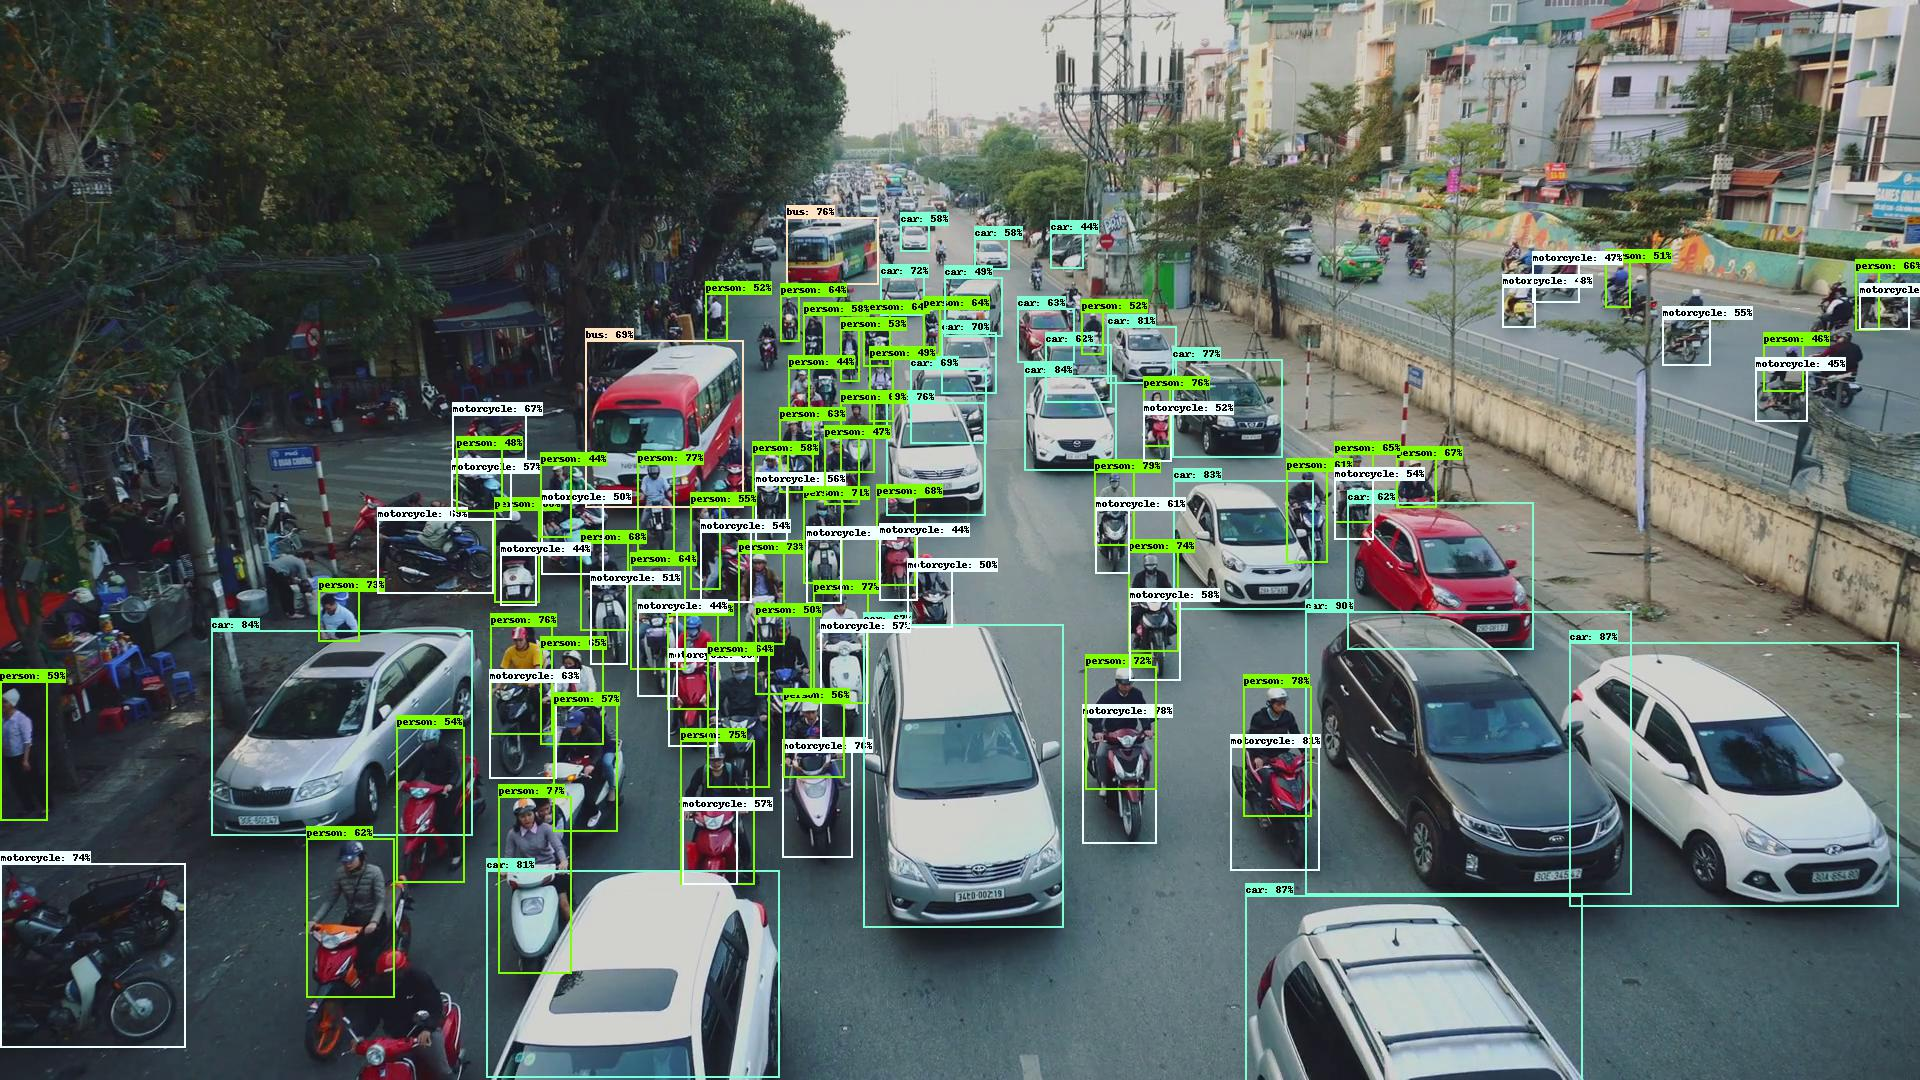

2. Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.

In [7]:
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import time
%matplotlib inline

# from google.colab import drive
# drive.mount('/gdrive')

import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

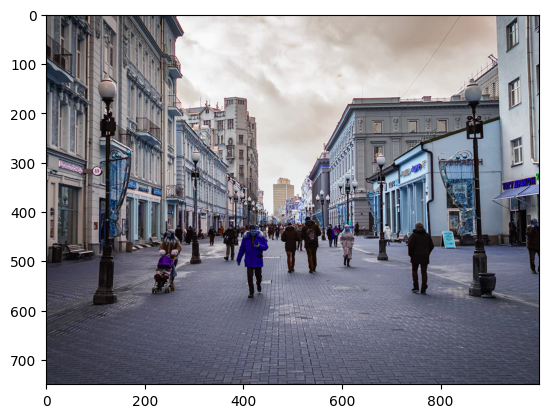

In [8]:
#Чтение картинки
im_path = '/content/drive/MyDrive/Geekbrains/Intro_Neural_Networks/Lesson7/756419dd-490c-4d53-96fa-ee8d0bbd664b.jpg'
image = cv2.imread(im_path)

plt.imshow(image)
plt.show()

In [9]:
# Загрузка детекторов
module_handle_faster_rcnn = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]
detector_faster_rcnn = hub.load(module_handle_faster_rcnn).signatures['default']

# Загрузка детектора
module_handle_ssd = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]
detector_ssd_mobilenet = hub.load(module_handle_ssd).signatures['default']

**Обработка изображения для передачи в детектор:**

In [10]:
# Формируем тензор
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [11]:
#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения,
# min_score=0.01 - минимакльная точность их детекции

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [12]:
# Выполняем детектор
def run_detector(detector, path, num_box):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()}

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=num_box)

  fig = plt.figure(figsize=(20, 12))
  plt.imshow(image_with_boxes)
  return result

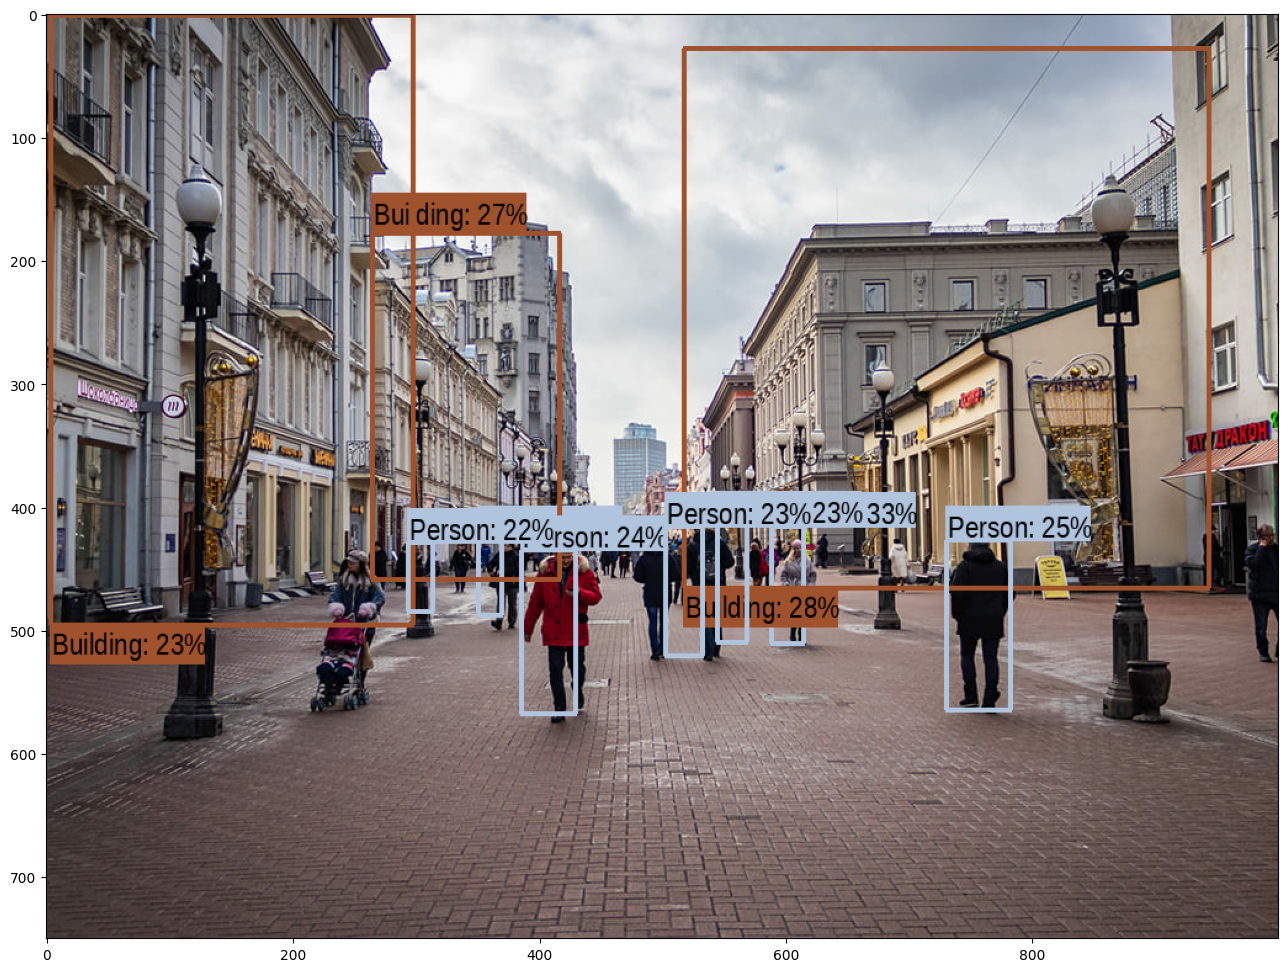

In [13]:
# Проверяем детекторы
result_rcnn_10 = run_detector(detector_faster_rcnn, im_path, 10)

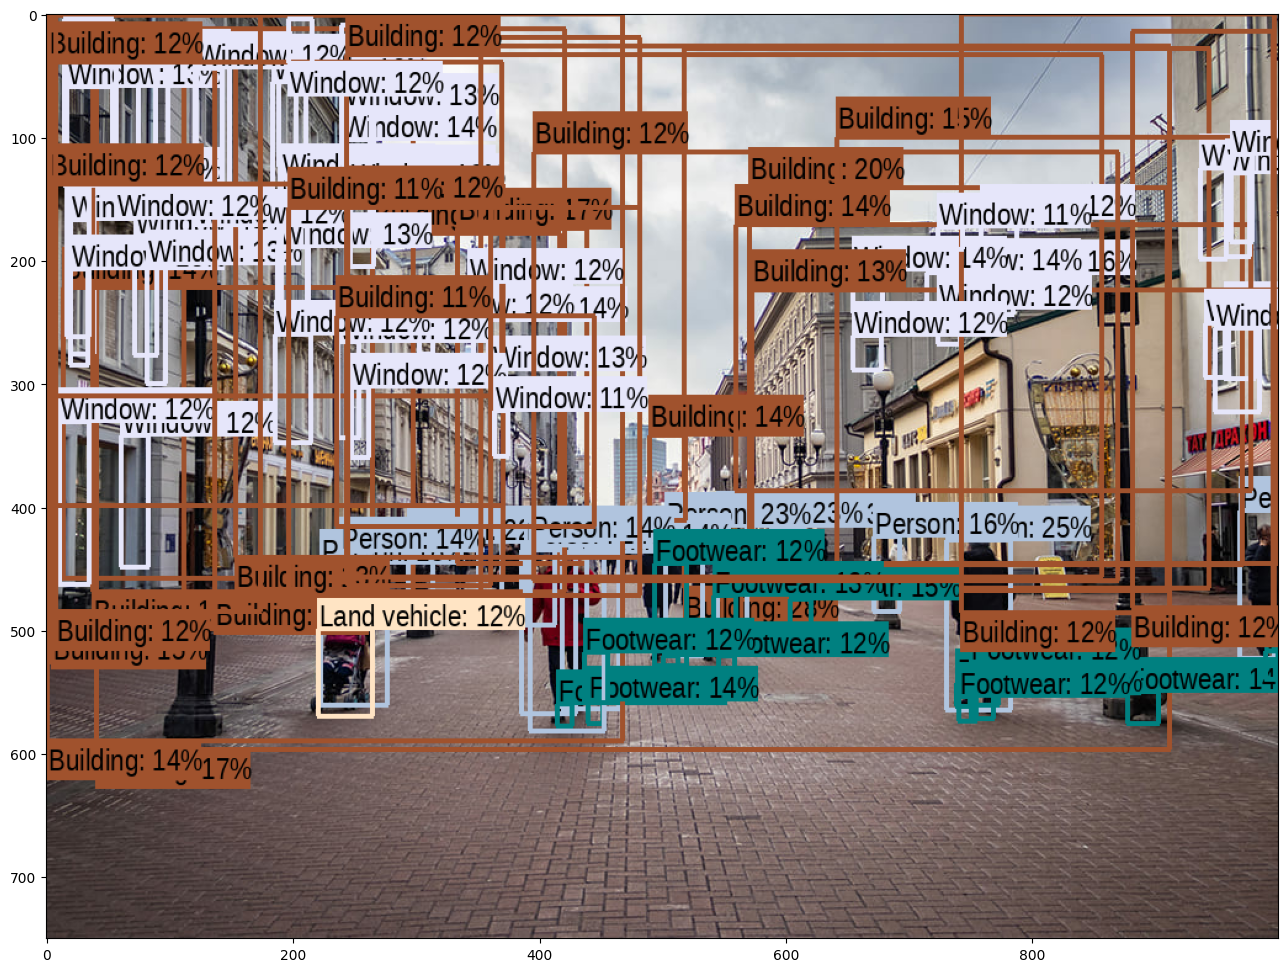

In [14]:
result_rcnn_100 = run_detector(detector_faster_rcnn, im_path, 100)